In [1]:
# 環境の問題：　 libiomp5.dylib というファイルがダブってる。その対応
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

## データのダウンロード

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## 前処理

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32")
x_train /= 255

x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test.astype("float32")
x_test /= 255

## 畳み込みネットワークの構築

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten
from tensorflow.keras.optimizers import SGD

model = Sequential()

model.add(
        Conv2D(filters=32,
                       kernel_size=(3,3),
                      padding="same",
                      input_shape=(28, 28,1),
                      activation="relu"
                      ))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10,
                               activation="softmax"
                               ))
model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=SGD(lr=0.1),
        metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                250890    
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________


## 学習の実行

In [5]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1
)

training_epochs = 30
batch_size = 64

history = model.fit(
        x_train,
        y_train,
        epochs=training_epochs,
        batch_size=batch_size,
        verbose=1,
        validation_split=0.2,
        shuffle=True,
        callbacks=[early_stopping]
        )

score = model.evaluate(x_test, y_test, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 63s 1ms/sample - loss: 0.5772 - accuracy: 0.8067 - val_loss: 0.4212 - val_accuracy: 0.8512
Epoch 2/30
48000/48000 [==============================] - 61s 1ms/sample - loss: 0.3930 - accuracy: 0.8611 - val_loss: 0.3667 - val_accuracy: 0.8702
Epoch 3/30
48000/48000 [==============================] - 60s 1ms/sample - loss: 0.3628 - accuracy: 0.8725 - val_loss: 0.3645 - val_accuracy: 0.8691
Epoch 4/30
48000/48000 [==============================] - 66s 1ms/sample - loss: 0.3391 - accuracy: 0.8791 - val_loss: 0.3409 - val_accuracy: 0.8803
Epoch 5/30
48000/48000 [==============================] - 60s 1ms/sample - loss: 0.3287 - accuracy: 0.8833 - val_loss: 0.3311 - val_accuracy: 0.8802
Epoch 6/30
48000/48000 [==============================] - 61s 1ms/sample - loss: 0.3164 - accuracy: 0.8861 - val_loss: 0.3089 - val_accuracy: 0.8922
Epoch 7/30
48000/48000 [==============================] 

## 損失と精度の推移をグラフに

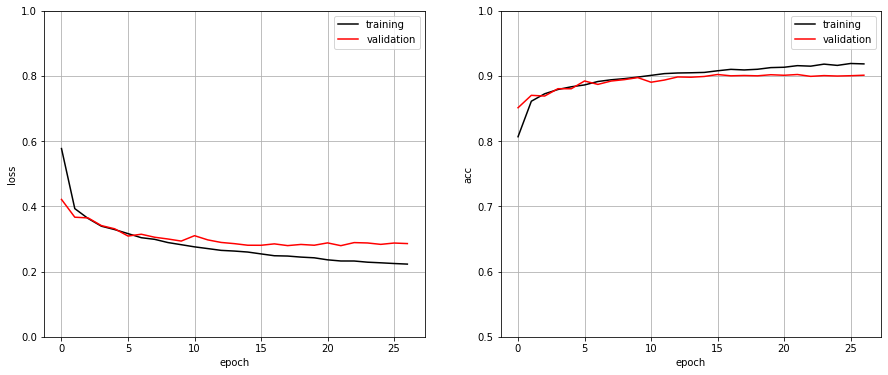

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)

plt.plot(history.history["loss"],
                label="training",
                color="black")

plt.plot(history.history["val_loss"],
                label="validation",
                color="red")
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")


plt.subplot(1,2,2)
plt.plot(history.history["accuracy"],
                label="training",
                color="black")

plt.plot(history.history["val_accuracy"],
                label="validation",
                color="red")
plt.ylim(0.5, 1)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()


## 5エポック以降は損失、正解率共にほぼ横ばいになっている。
## しかし、訓練データの損失は5エポック以降も下がり続け、正解率は上昇を続けている。ドロップアウトを適用したが、若干のオーバーフィッティングが発生していると考えられる。
## この解決法として正則化が考えられる。